<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/name_classification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name-Classification - Example

In [508]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import compress
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef
from sklearn.model_selection import train_test_split

In [433]:
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [434]:
from nltk.corpus import names

In [435]:
male_names = names.words('male.txt')
female_names = names.words('female.txt')

label2idx = {'male':0, 'female': 1}
X = male_names + female_names
y = [label2idx['male']] * len(male_names) + [label2idx['female']] * len(female_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=1234, stratify=y)

print("training set size: ", len(X_train), "test set size: ", len(X_test))

training set size:  5958 test set size:  1986


# Data Analysis

## Prepare the training set for analysis

We use only the training set for the analysis, to prevent bias in our features.

In [436]:
train_males = [name for idx, name in enumerate(X_train) if y_train[idx] == 0]
train_females = [name for idx, name in enumerate(X_train) if y_train[idx] == 1]

print("there are: ", len(train_males), "males and ", len(train_females), "female names in the training set")

there are:  2207 males and  3751 female names in the training set


In [437]:
sum_letters_male = sum([len(name) for name in train_males])
sum_letters_female = sum([len(name) for name in train_females])

print("there are: ", sum_letters_male, " letters for males and ", sum_letters_female, "letters in the female names, in the training set")

there are:  13074  letters for males and  22927 letters in the female names, in the training set


In [438]:
df_train = pd.DataFrame({"names": X_train, "gender": y_train})

## Duplicated Names

In [439]:
duplicated_names = df_train["names"][df_train["names"].duplicated()]
duplicated_names

,names
405,Noel
659,Kerry
681,Chris
735,Tate
1074,Darcy
...,...
5852,Deane
5858,Wallie
5869,Rene
5902,Penny


If we want to have a clean dataset, we can remove the duplicated names up front:

In [440]:
df_train = df_train.drop_duplicates(subset=['names'])


## Name Length as a feature
Let's add the name length:

In [441]:
df_train["name_length"] = df_train["names"].apply(len)
df_train

,names,gender,name_length
0,Angie,0,5
1,Rivkah,1,6
2,Marty,1,5
3,Rudolf,0,6
4,Deedee,1,6
...,...,...,...
5952,Gwenora,1,7
5953,Heida,1,5
5954,Glennis,1,7
5955,Skelly,0,6


...So we can analyze it:

In [442]:
df_train[df_train["gender"]==1].describe() - df_train[df_train["gender"]==0].describe()

,gender,name_length
count,1555.0,1555.000000
mean,1.0,0.183592
std,0.0,-0.040985
min,1.0,0.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.000000
max,1.0,0.000000


We can clearly see that the differences of the name length are not so significant: nearly the same maen, same minimum and maximum too.

## N-Grams as a feature

Analyzing the n-grams with CountVectorizer.

We use CountVectorizer to extract all possible ngrams (sizes 1-3 letters), for each gender names.  
Hosting it in a pandas dataframe allows us to explore it further.

In [443]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 3))

def get_ngrams(name_list: list, col_names: list) -> pd.DataFrame:
    ngram_counts = vectorizer.fit_transform(name_list)
    feature_names = vectorizer.get_feature_names_out()
    total_counts = ngram_counts.sum(axis=0).A1
    multiple_ngram_counts = (ngram_counts > 1).sum(axis=0).A1
    return pd.DataFrame({col_names[0]: total_counts, col_names[1]: multiple_ngram_counts}, index=feature_names)

df_female_ngrams = get_ngrams(train_females, ["occur_in_female_names", "female_multiple_ngrams_count"])
df_male_ngrams = get_ngrams(train_males, ["ngram_occur_in_male_names", "male_multiple_ngrams_count"])

df_feature_exploration_merged = df_female_ngrams.join(df_male_ngrams, how="outer")
df_feature_exploration_merged

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count
,3.0,0.0,NaN,NaN
a,1.0,0.0,NaN,NaN
an,1.0,0.0,NaN,NaN
d,1.0,0.0,NaN,NaN
de,1.0,0.0,NaN,NaN
...,...,...,...,...
zy,4.0,0.0,1.0,0.0
zz,5.0,0.0,2.0,0.0
zze,1.0,0.0,NaN,NaN
zzi,2.0,0.0,1.0,0.0


In [444]:
df_feature_exploration_merged.describe()

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count
count,2401.000000,2401.000000,2553.000000,2553.000000
mean,23.960017,1.400666,12.769683,0.542891
std,138.297921,25.357729,66.872271,8.127259
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,4.000000,0.000000,3.000000,0.000000
75%,11.000000,0.000000,7.000000,0.000000
max,3430.000000,786.000000,1471.000000,242.000000


In [445]:
df_feature_exploration_merged["occur_in_female_names_pct"] = df_feature_exploration_merged["occur_in_female_names"] / df_feature_exploration_merged["occur_in_female_names"].sum() * 100.
df_feature_exploration_merged["ngram_occur_in_male_names_pct"] = df_feature_exploration_merged["ngram_occur_in_male_names"] / df_feature_exploration_merged["ngram_occur_in_male_names"].sum() * 100.

df_feature_exploration_merged["pct_diff"] = df_feature_exploration_merged["occur_in_female_names_pct"] - df_feature_exploration_merged["ngram_occur_in_male_names_pct"]

In [446]:
df_feature_exploration_merged.sort_values("occur_in_female_names", ascending=False).head(20)

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count,occur_in_female_names_pct,ngram_occur_in_male_names_pct,pct_diff
a,3430.0,786.0,1278.0,137.0,5.962314,3.920125,2.042189
e,3114.0,728.0,1471.0,242.0,5.413016,4.512132,0.900885
i,2238.0,243.0,923.0,80.0,3.890280,2.831201,1.059078
n,2080.0,385.0,1006.0,140.0,3.615631,3.085795,0.529836
l,1946.0,344.0,871.0,134.0,3.382701,2.671697,0.711003
r,1697.0,138.0,1214.0,149.0,2.949868,3.723812,-0.773944
t,1022.0,178.0,663.0,79.0,1.776526,2.033680,-0.257154
o,877.0,42.0,852.0,96.0,1.524475,2.613417,-1.088942
s,850.0,110.0,604.0,60.0,1.477541,1.852704,-0.375163
d,768.0,46.0,543.0,48.0,1.335002,1.665593,-0.330591


In [447]:
df_feature_exploration_merged.sort_values("ngram_occur_in_male_names", ascending=False).head(20)

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count,occur_in_female_names_pct,ngram_occur_in_male_names_pct,pct_diff
e,3114.0,728.0,1471.0,242.0,5.413016,4.512132,0.900885
a,3430.0,786.0,1278.0,137.0,5.962314,3.920125,2.042189
r,1697.0,138.0,1214.0,149.0,2.949868,3.723812,-0.773944
n,2080.0,385.0,1006.0,140.0,3.615631,3.085795,0.529836
i,2238.0,243.0,923.0,80.0,3.890280,2.831201,1.059078
l,1946.0,344.0,871.0,134.0,3.382701,2.671697,0.711003
o,877.0,42.0,852.0,96.0,1.524475,2.613417,-1.088942
t,1022.0,178.0,663.0,79.0,1.776526,2.033680,-0.257154
s,850.0,110.0,604.0,60.0,1.477541,1.852704,-0.375163
d,768.0,46.0,543.0,48.0,1.335002,1.665593,-0.330591


<Axes: >

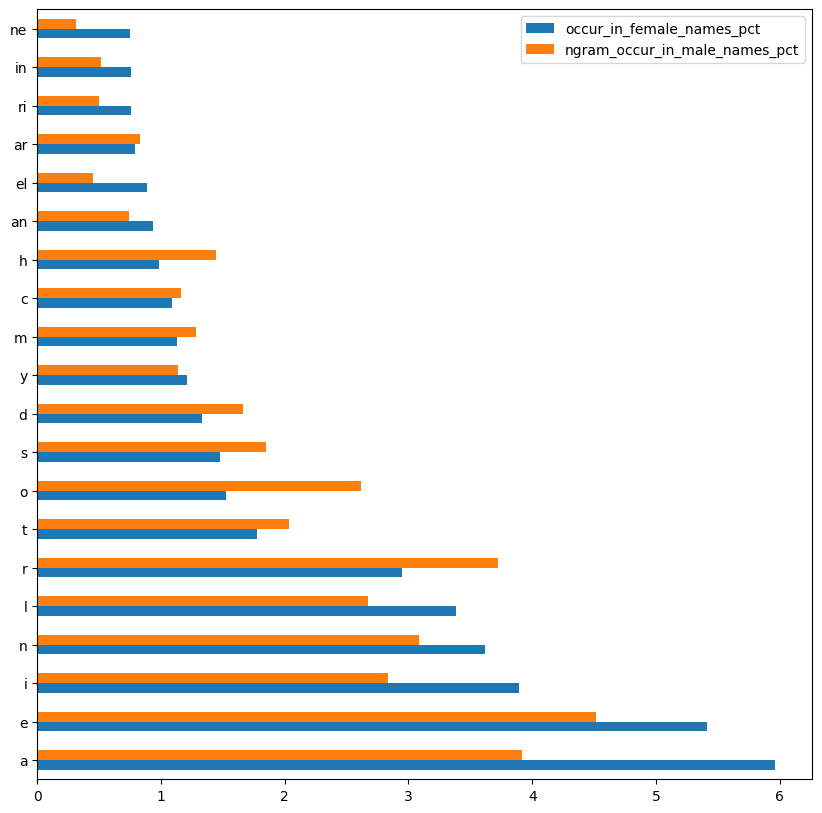

In [448]:
df_feature_exploration_merged.sort_values("occur_in_female_names", ascending=False).head(20)[["occur_in_female_names_pct", "ngram_occur_in_male_names_pct"]].plot.barh(figsize=(10,10))

In [449]:
df_feature_exploration_merged.sort_values("pct_diff", ascending=False).head(20)

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count,occur_in_female_names_pct,ngram_occur_in_male_names_pct,pct_diff
a,3430.0,786.0,1278.0,137.0,5.962314,3.920125,2.042189
i,2238.0,243.0,923.0,80.0,3.890280,2.831201,1.059078
e,3114.0,728.0,1471.0,242.0,5.413016,4.512132,0.900885
l,1946.0,344.0,871.0,134.0,3.382701,2.671697,0.711003
na,427.0,6.0,60.0,1.0,0.742247,0.184043,0.558204
n,2080.0,385.0,1006.0,140.0,3.615631,3.085795,0.529836
li,418.0,5.0,91.0,0.0,0.726603,0.279133,0.447470
ne,431.0,2.0,103.0,0.0,0.749200,0.315941,0.433259
el,509.0,1.0,148.0,0.0,0.884787,0.453974,0.430813
nn,303.0,1.0,53.0,0.0,0.526700,0.162572,0.364128


<Axes: >

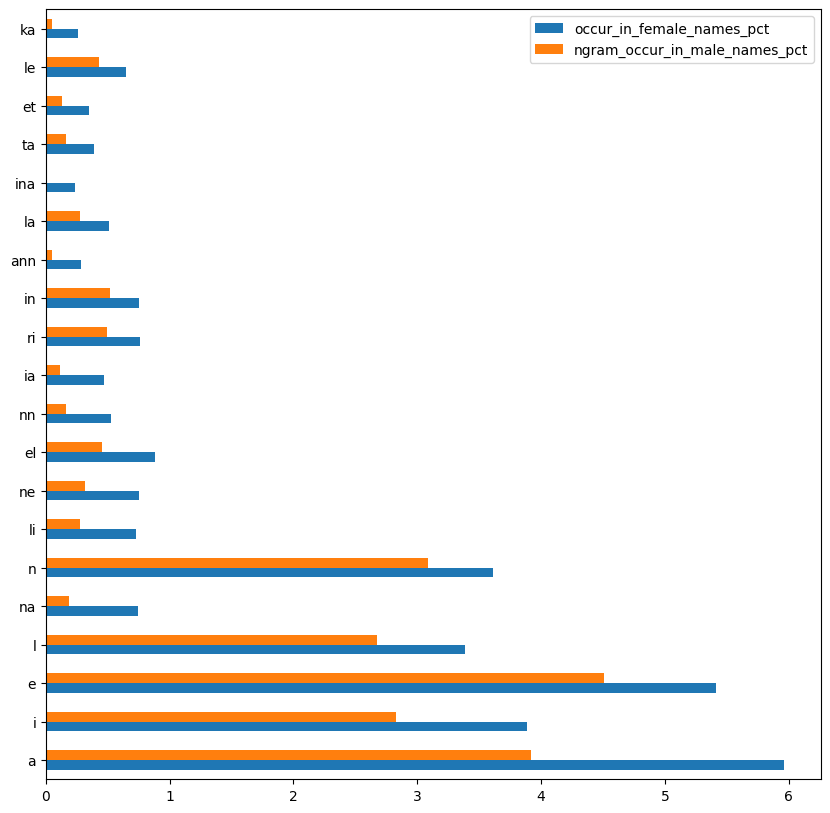

In [450]:
df_feature_exploration_merged.sort_values("pct_diff", ascending=False).head(20)[["occur_in_female_names_pct", "ngram_occur_in_male_names_pct"]].plot.barh(figsize=(10,10))

In [451]:
df_feature_exploration_merged.sort_values("pct_diff", ascending=True).head(20)

,occur_in_female_names,female_multiple_ngrams_count,ngram_occur_in_male_names,male_multiple_ngrams_count,occur_in_female_names_pct,ngram_occur_in_male_names_pct,pct_diff
o,877.0,42.0,852.0,96.0,1.524475,2.613417,-1.088942
r,1697.0,138.0,1214.0,149.0,2.949868,3.723812,-0.773944
w,75.0,2.0,206.0,4.0,0.130371,0.631882,-0.501511
u,302.0,7.0,321.0,9.0,0.524962,0.984632,-0.459671
h,566.0,24.0,470.0,29.0,0.983869,1.441674,-0.457805
er,262.0,0.0,283.0,2.0,0.455430,0.868072,-0.412641
s,850.0,110.0,604.0,60.0,1.477541,1.852704,-0.375163
d,768.0,46.0,543.0,48.0,1.335002,1.665593,-0.330591
on,156.0,0.0,193.0,2.0,0.271172,0.592006,-0.320834
f,153.0,13.0,188.0,31.0,0.265957,0.576669,-0.310712


<Axes: >

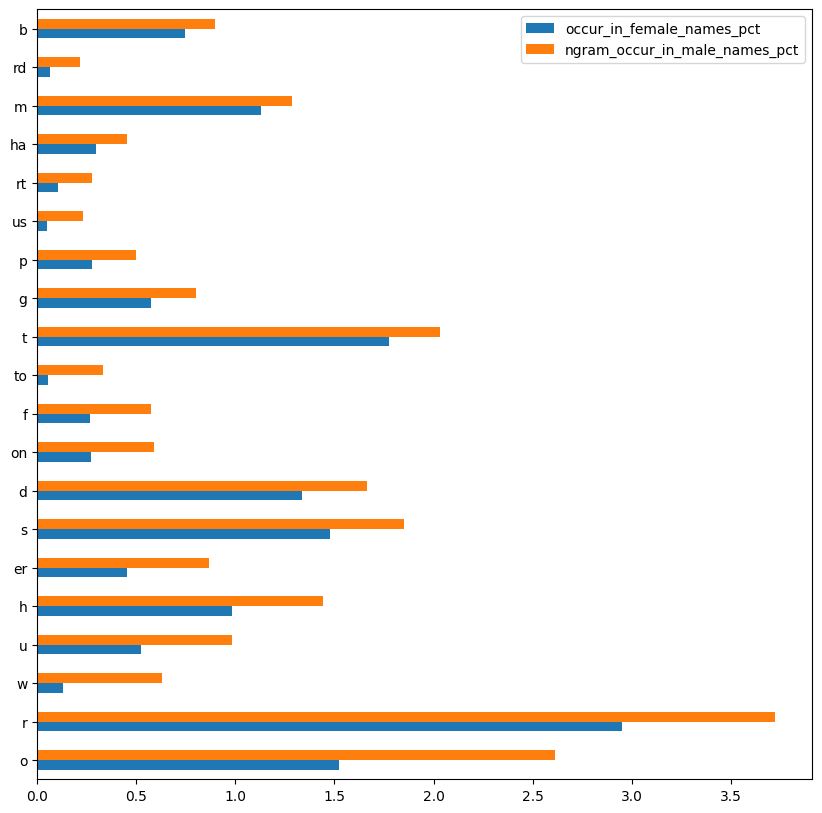

In [452]:
df_feature_exploration_merged.sort_values("pct_diff", ascending=True).head(20)[["occur_in_female_names_pct", "ngram_occur_in_male_names_pct"]].plot.barh(figsize=(10,10))

### Unique n-grams per class
Let's find the unique ngrams for each class:

In [453]:
clearly_female_ngrams = df_feature_exploration_merged[df_feature_exploration_merged["ngram_occur_in_male_names"].isna()].index.to_list()
clearly_male_ngrams = df_feature_exploration_merged[df_feature_exploration_merged["occur_in_female_names"].isna()].index.to_list()

print("female", clearly_female_ngrams, "\nmale", clearly_male_ngrams)

female [' ', ' a', ' an', ' d', ' de', '-a', '-an', '-di', '-e', '-el', '-g', '-gr', '-j', '-je', '-jo', '-k', '-ka', '-ly', 'a-', 'a-a', 'a-d', 'a-g', 'a-k', 'a-l', 'a-m', 'aan', 'abs', 'aca', 'acq', 'aed', 'aeg', 'aer', 'afn', 'agd', 'agg', 'agm', 'agr', 'ahl', 'aia', 'aib', 'aka', 'aln', 'amy', 'anj', 'any', 'aom', 'aph', 'app', 'apr', 'arj', 'arq', 'asl', 'asm', 'asy', 'atl', 'ats', 'atu', 'aty', 'aux', 'avl', 'ayc', 'ayi', 'azm', 'azs', 'bag', 'bam', 'bbr', 'beb', 'bee', 'bei', 'bek', 'bet', 'beu', 'bev', 'bh', 'bha', 'bid', 'big', 'bir', 'bit', 'ble', 'bli', 'bly', 'buf', 'bun', 'bye', 'byl', 'byn', 'cac', 'cap', 'cca', 'cea', 'ced', 'cee', 'cet', 'chk', 'chl', 'cic', 'cif', 'cin', 'cit', 'ckl', 'ckq', 'clo', 'coi', 'cq', 'cqu', 'cry', 'cta', 'ctr', 'cun', 'cyb', 'cyn', 'cz', 'czk', 'dac', 'dae', 'daf', 'dag', 'dap', 'dat', 'dau', 'day', 'deb', 'ded', 'deg', 'deh', 'dei', 'dev', 'dey', 'did', 'div', 'dix', 'diy', 'dli', 'dod', 'doe', 'dos', 'dot', 'dsi', 'dyc', 'dye', 'dyn', 'dyt

And ensure they are indeed unique:

In [454]:
set(clearly_male_ngrams).intersection(clearly_female_ngrams)

set()

We can also use the top/bottom differences as features:

In [455]:
top_different_letters_for_female = df_feature_exploration_merged.nlargest(10, "pct_diff")["pct_diff"].to_dict()
top_different_letters_for_male = df_feature_exploration_merged.nsmallest(10, "pct_diff")["pct_diff"].to_dict()

print(top_different_letters_for_female)
print(top_different_letters_for_male)

{'a': 2.04218885408034, 'i': 1.0590780191751454, 'e': 0.9008847406302447, 'l': 0.7110034107668377, 'na': 0.5582038192608505, 'n': 0.5298357351564564, 'li': 0.4474701558701492, 'ne': 0.4332591605789457, 'el': 0.43081273424444166, 'nn': 0.3641283414642218}
{'o': -1.088941728114613, 'r': -0.7739442625828623, 'w': -0.5015111601381731, 'u': -0.45967061548733823, 'h': -0.4578048435005686, 'er': -0.4126411324381135, 's': -0.37516253362980434, 'd': -0.33059099402611314, 'on': -0.32083408146567066, 'f': -0.31071198050966986}


## Last-letter as a feature

In [456]:
males_last_letter = Counter([name.strip()[-1] for name in train_males])
females_last_letter = Counter([name.strip()[-1] for name in train_females])

# calculate the percentages of males_last_letter
males_last_letter_pct = {k: v / sum(males_last_letter.values()) * 100 for k, v in males_last_letter.items()}
females_last_letter_pct = {k: v / sum(females_last_letter.values()) * 100 for k, v in females_last_letter.items()}

<Axes: >

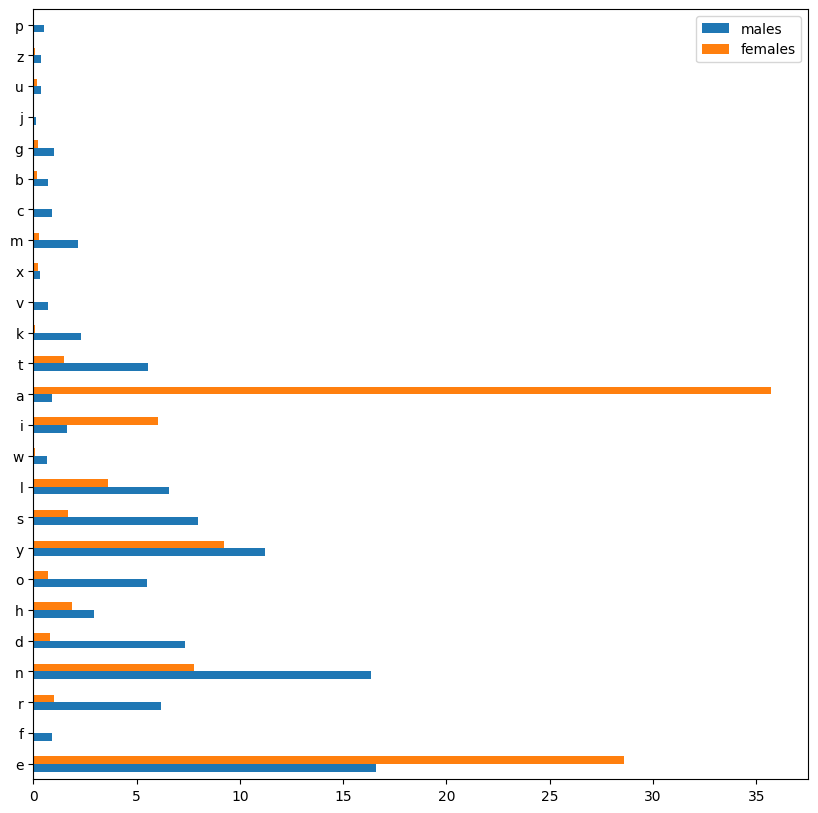

In [457]:
pd.DataFrame([males_last_letter_pct, females_last_letter_pct], index=["males", "females"]).T.plot.barh(figsize=(10,10))

In [458]:
clear_male_ending_letters = set(males_last_letter_pct.keys()).difference(females_last_letter_pct.keys())
clear_male_ending_letters

{'c', 'j'}

In [459]:
set(females_last_letter_pct.keys()).difference(males_last_letter_pct.keys())

set()

In [460]:
# calcualte the percentage differences between males_last_letter_pct and females_last_letter_pct
male_last_letter_pct_diff = {k: v - females_last_letter_pct.get(k, 0) for k, v in males_last_letter_pct.items()}
male_last_letter_pct_diff_pos = dict(filter(lambda x: x[1] > 0, male_last_letter_pct_diff.items()))
male_last_letter_pct_diff_pos

{'f': 0.8795479640710823,
 'r': 5.194458339277476,
 'n': 8.572454987686712,
 'd': 6.540494200791282,
 'h': 1.0523458659023057,
 'o': 4.808057830100465,
 'y': 2.0127663887122935,
 's': 6.2950740699625545,
 'l': 2.944304717654509,
 'w': 0.5730174113364364,
 't': 4.080241040087543,
 'k': 2.2308505075281544,
 'v': 0.6983064597665967,
 'x': 0.0772366154707333,
 'm': 1.9083024771403658,
 'c': 0.9062075215224286,
 'b': 0.5650086725098651,
 'g': 0.783551814063901,
 'j': 0.1359311282283643,
 'u': 0.20252566390089363,
 'z': 0.28250433625493254,
 'p': 0.517064955462111}

In [461]:
# calcualte the percentage differences between females_last_letter_pct and males_last_letter_pct
female_last_letter_pct_diff = {k: v - males_last_letter_pct.get(k, 0) for k, v in females_last_letter_pct.items()}
female_last_letter_pct_diff_pos = dict(filter(lambda x: x[1] > 0, female_last_letter_pct_diff.items()))
female_last_letter_pct_diff_pos

{'e': 12.022107501434142, 'a': 34.817599463281624, 'i': 4.420546002715241}

## Extracting Vowels features


In [462]:
# count how many differnet vowels are in each name
train_males_vowels = [[name.lower().count(v) for v in "aeiou"] for name in train_males]
train_females_vowels = [[name.lower().count(v) for v in "aeiou"] for name in train_females]
pd.DataFrame(train_males_vowels, columns=list("aeiou")).describe()

,a,e,i,o,u
count,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,0.579067,0.666516,0.418215,0.386044,0.145446
std,0.617056,0.697280,0.570103,0.586603,0.366498
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,4.000000,3.000000,3.000000,3.000000


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'i'}>, <Axes: title={'center': 'o'}>],
       [<Axes: title={'center': 'u'}>, <Axes: >]], dtype=object)

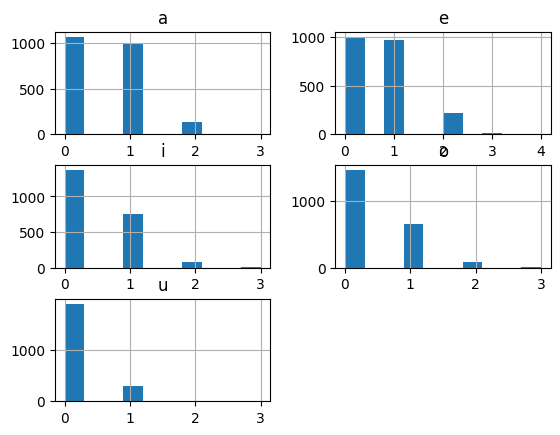

In [463]:
pd.DataFrame(train_males_vowels, columns=list("aeiou")).hist()

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'e'}>],
       [<Axes: title={'center': 'i'}>, <Axes: title={'center': 'o'}>],
       [<Axes: title={'center': 'u'}>, <Axes: >]], dtype=object)

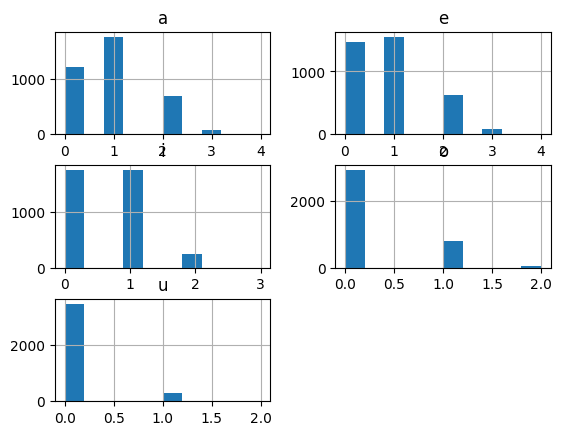

In [464]:
pd.DataFrame(train_females_vowels, columns=list("aeiou")).hist()

<Axes: >

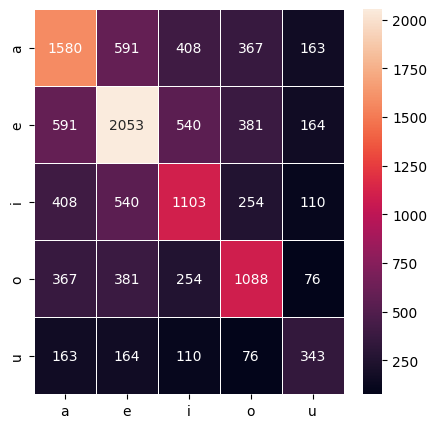

In [465]:
f, ax = plt.subplots(figsize=(5, 5))
X = np.matrix(train_males_vowels)
sns.heatmap(pd.DataFrame(X.T * X, columns=list("aeiou"), index=list("aeiou")), annot=True, fmt="d", linewidths=.5, ax=ax)

<Axes: >

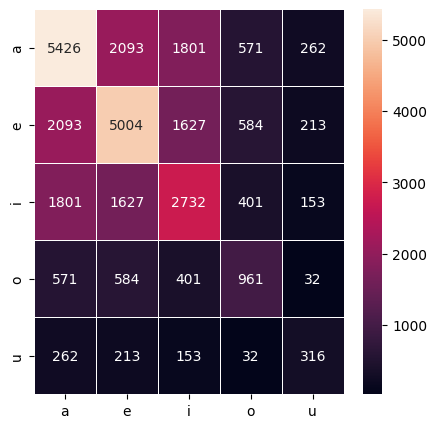

In [466]:
f, ax = plt.subplots(figsize=(5, 5))
X = np.matrix(train_females_vowels)
sns.heatmap(pd.DataFrame(X.T * X, columns=list("aeiou"), index=list("aeiou")), annot=True, fmt="d", linewidths=.5, ax=ax)

#### Analysis
It seems that "o" tends more towards male names, especially when combained with "a" and "e".   
The letter "a" - especifically in combination with "e" and i", tends more towards the female names.
"u" as well might tend towards males.

## Bi-variate features (co-occurences)

We're using here a little linear algebra trick.  
After we have a table of each letter's document-occurernceses, [we multiple it by itself, transposed](https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas), to get the co-occurrence matrix: \begin{equation}
A \cdot A^T
\end{equation}

In [467]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 1))
def get_cooccurrences(name_list: list, col_names: list) -> pd.DataFrame:
  X = vectorizer.fit_transform(name_list)
  Xc = (X.T * X)
  Xc.setdiag(0)
  df_cooccurrences = pd.DataFrame(data=Xc.todense(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
  return df_cooccurrences

df_female_ngrams = get_cooccurrences(train_females, ["occur_in_female_names", "female_multiple_ngrams_count"])
df_male_ngrams = get_cooccurrences(train_males, ["ngram_occur_in_male_names", "male_multiple_ngrams_count"])


<Axes: >

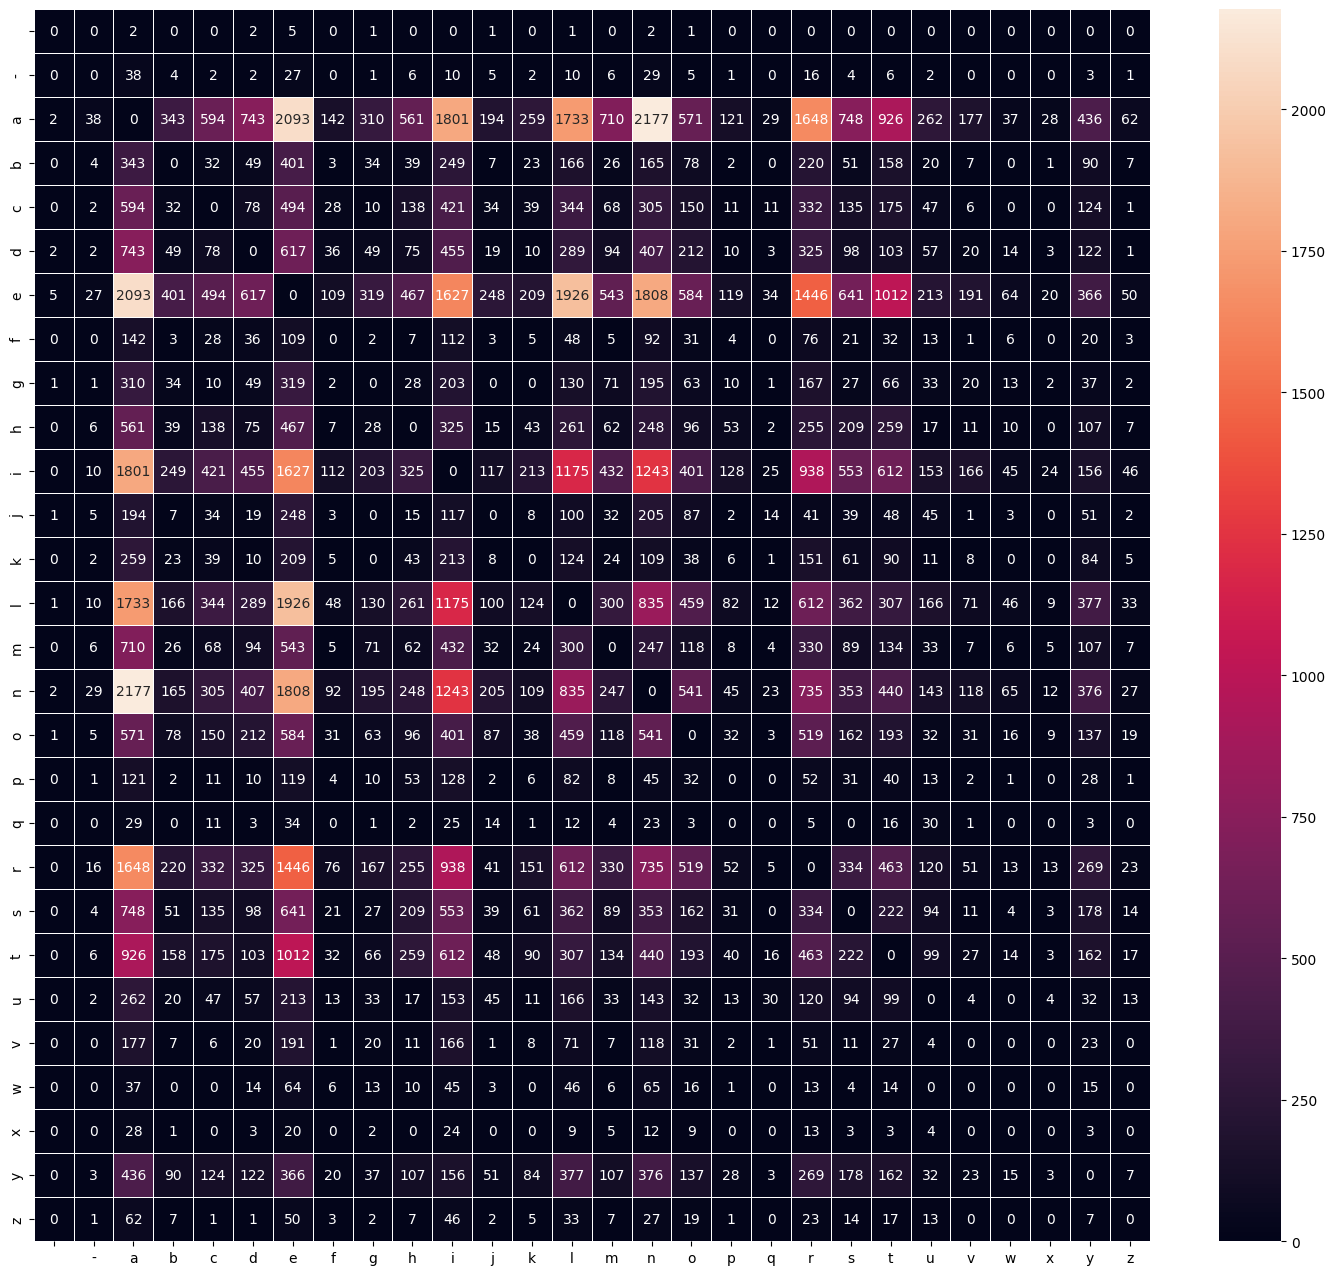

In [468]:
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(df_female_ngrams, annot=True, fmt="d", linewidths=.5, ax=ax)

<Axes: >

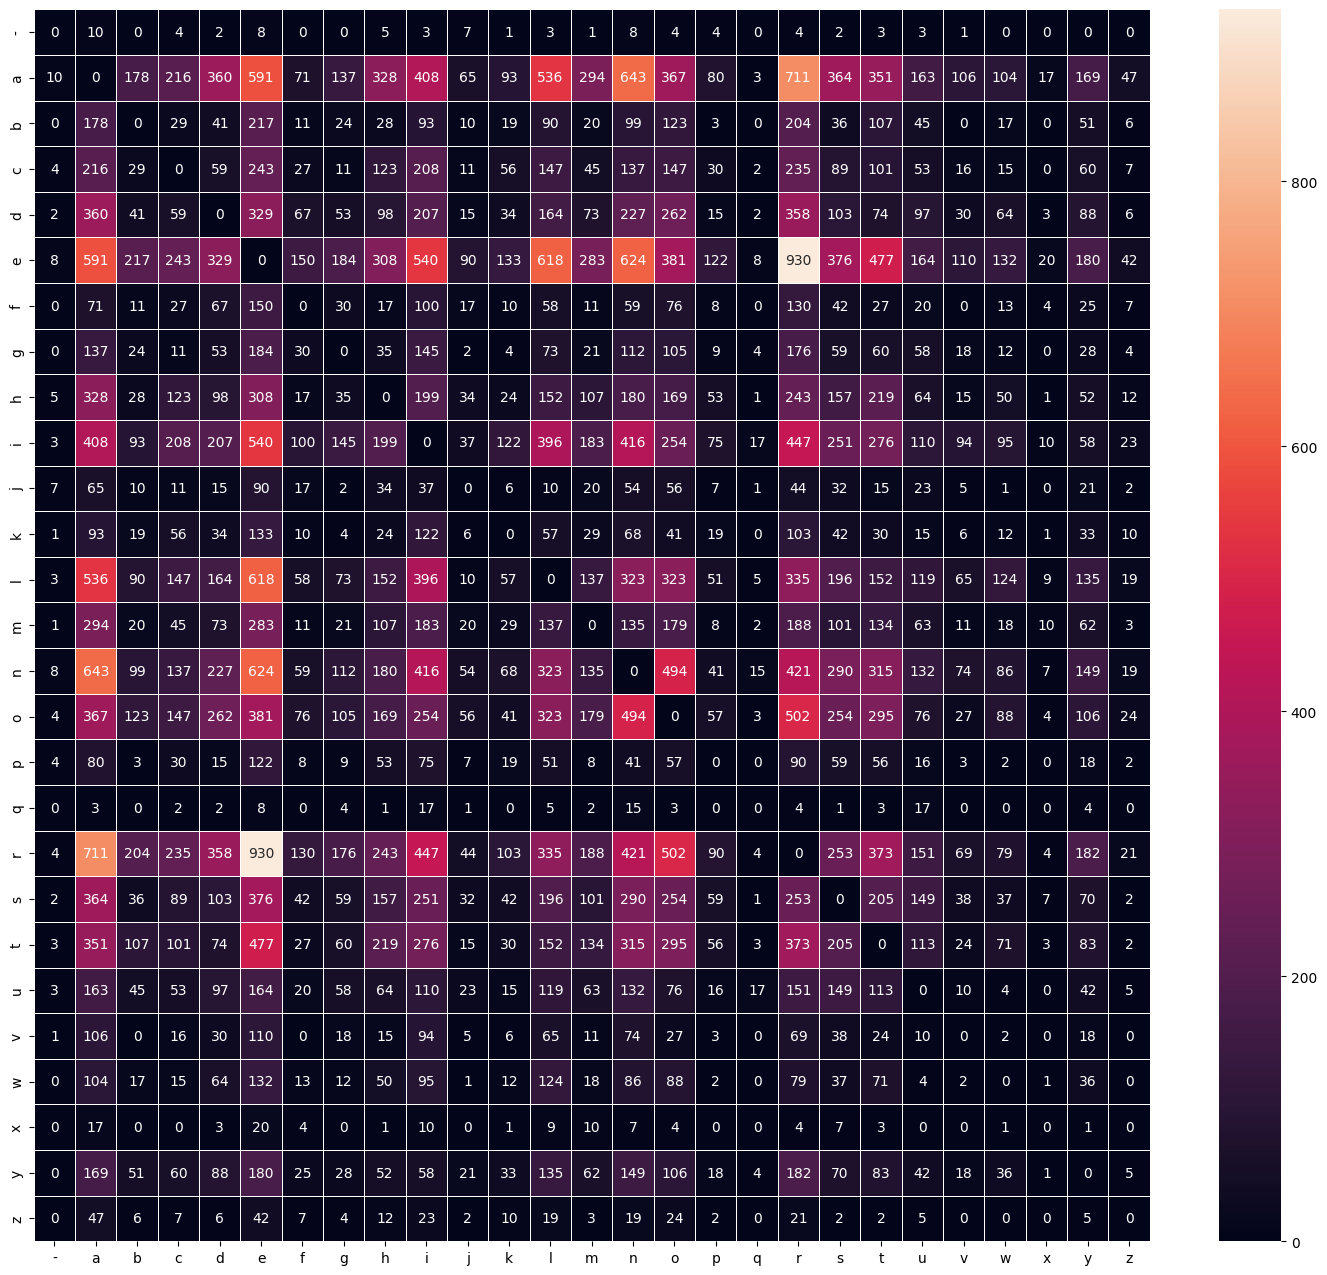

In [469]:
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(df_male_ngrams, annot=True, fmt="d", linewidths=.4, ax=ax)

<Axes: >

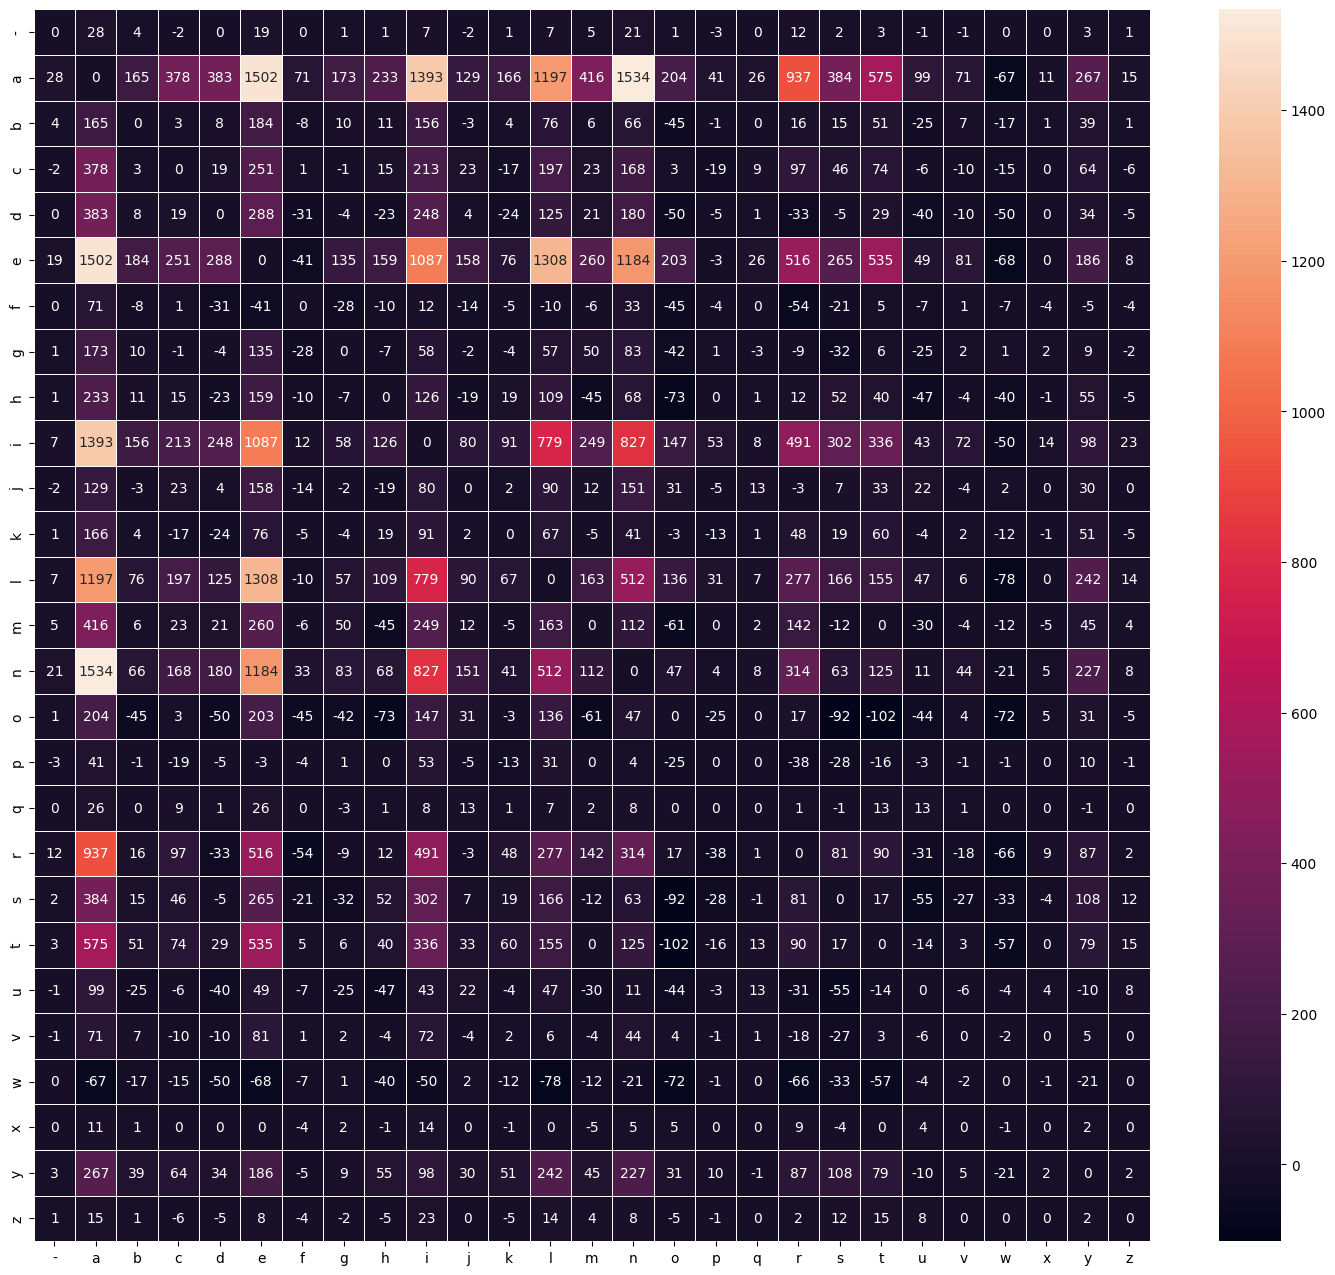

In [470]:
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(df_female_ngrams.iloc[1:, 1:] - df_male_ngrams, annot=True, fmt="d", linewidths=.5, ax=ax)

In [471]:
female_coocurrence_threshold = 300
df_female_ngrams[df_female_ngrams > female_coocurrence_threshold].dropna(axis=0, how="all").dropna(axis=1, how="all")

,a,b,c,d,e,g,h,i,l,m,n,o,r,s,t,y
a,NaN,343.0,594.0,743.0,2093.0,310.0,561.0,1801.0,1733.0,710.0,2177.0,571.0,1648.0,748.0,926.0,436.0
b,343.0,NaN,NaN,NaN,401.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c,594.0,NaN,NaN,NaN,494.0,NaN,NaN,421.0,344.0,NaN,305.0,NaN,332.0,NaN,NaN,NaN
d,743.0,NaN,NaN,NaN,617.0,NaN,NaN,455.0,NaN,NaN,407.0,NaN,325.0,NaN,NaN,NaN
e,2093.0,401.0,494.0,617.0,NaN,319.0,467.0,1627.0,1926.0,543.0,1808.0,584.0,1446.0,641.0,1012.0,366.0
g,310.0,NaN,NaN,NaN,319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
h,561.0,NaN,NaN,NaN,467.0,NaN,NaN,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i,1801.0,NaN,421.0,455.0,1627.0,NaN,325.0,NaN,1175.0,432.0,1243.0,401.0,938.0,553.0,612.0,NaN
l,1733.0,NaN,344.0,NaN,1926.0,NaN,NaN,1175.0,NaN,NaN,835.0,459.0,612.0,362.0,307.0,377.0
m,710.0,NaN,NaN,NaN,543.0,NaN,NaN,432.0,NaN,NaN,NaN,NaN,330.0,NaN,NaN,NaN


In [472]:
female_above_threshold = df_female_ngrams[df_female_ngrams > female_coocurrence_threshold].dropna(axis=0, how="all").dropna(axis=1, how="all")
letter_combinations = set(map(frozenset, list(zip(*np.where(~np.isnan(female_above_threshold))))))
female_letter_combinations = [(female_above_threshold.columns[letter1], female_above_threshold.columns[letter2]) for letter1, letter2 in letter_combinations]
female_letter_combinations

[('n', 'e'),
 ('l', 'c'),
 ('b', 'e'),
 ('e', 'h'),
 ('n', 'y'),
 ('o', 'r'),
 ('l', 't'),
 ('e', 'g'),
 ('a', 'r'),
 ('m', 'i'),
 ('a', 'g'),
 ('l', 'i'),
 ('t', 'i'),
 ('n', 's'),
 ('a', 'o'),
 ('m', 'e'),
 ('n', 'o'),
 ('a', 's'),
 ('d', 'e'),
 ('a', 'h'),
 ('n', 'i'),
 ('a', 'd'),
 ('e', 's'),
 ('a', 'c'),
 ('a', 'e'),
 ('l', 'n'),
 ('c', 'e'),
 ('d', 'r'),
 ('o', 'e'),
 ('a', 'i'),
 ('l', 'y'),
 ('l', 'r'),
 ('m', 'r'),
 ('e', 'i'),
 ('d', 'i'),
 ('a', 'n'),
 ('a', 'b'),
 ('h', 'i'),
 ('n', 'r'),
 ('e', 't'),
 ('l', 's'),
 ('o', 'i'),
 ('c', 'i'),
 ('a', 'l'),
 ('a', 'm'),
 ('r', 'i'),
 ('l', 'o'),
 ('c', 'n'),
 ('s', 'i'),
 ('r', 't'),
 ('e', 'y'),
 ('e', 'r'),
 ('n', 'd'),
 ('c', 'r'),
 ('n', 't'),
 ('a', 'y'),
 ('a', 't'),
 ('r', 's'),
 ('l', 'e')]

In [473]:
male_coocurrence_threshold = 200
df_male_ngrams[df_male_ngrams > male_coocurrence_threshold].dropna(axis=0, how="all").dropna(axis=1, how="all")

,a,b,c,d,e,h,i,l,m,n,o,r,s,t
a,NaN,NaN,216.0,360.0,591.0,328.0,408.0,536.0,294.0,643.0,367.0,711.0,364.0,351.0
b,NaN,NaN,NaN,NaN,217.0,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,NaN
c,216.0,NaN,NaN,NaN,243.0,NaN,208.0,NaN,NaN,NaN,NaN,235.0,NaN,NaN
d,360.0,NaN,NaN,NaN,329.0,NaN,207.0,NaN,NaN,227.0,262.0,358.0,NaN,NaN
e,591.0,217.0,243.0,329.0,NaN,308.0,540.0,618.0,283.0,624.0,381.0,930.0,376.0,477.0
h,328.0,NaN,NaN,NaN,308.0,NaN,NaN,NaN,NaN,NaN,NaN,243.0,NaN,219.0
i,408.0,NaN,208.0,207.0,540.0,NaN,NaN,396.0,NaN,416.0,254.0,447.0,251.0,276.0
l,536.0,NaN,NaN,NaN,618.0,NaN,396.0,NaN,NaN,323.0,323.0,335.0,NaN,NaN
m,294.0,NaN,NaN,NaN,283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n,643.0,NaN,NaN,227.0,624.0,NaN,416.0,323.0,NaN,NaN,494.0,421.0,290.0,315.0


In [474]:
male_above_threshold = df_male_ngrams[df_male_ngrams > male_coocurrence_threshold].dropna(axis=0, how="all").dropna(axis=1, how="all")
letter_combinations = set(map(frozenset, list(zip(*np.where(~np.isnan(male_above_threshold))))))
male_letter_combinations = [(male_above_threshold.columns[letter1], male_above_threshold.columns[letter2]) for letter1, letter2 in letter_combinations]
male_letter_combinations

[('o', 'e'),
 ('b', 'e'),
 ('e', 'i'),
 ('n', 'd'),
 ('r', 's'),
 ('c', 'i'),
 ('e', 'h'),
 ('a', 's'),
 ('n', 'l'),
 ('a', 'h'),
 ('o', 't'),
 ('t', 'i'),
 ('a', 'r'),
 ('t', 'h'),
 ('c', 'r'),
 ('n', 'e'),
 ('o', 'r'),
 ('r', 'i'),
 ('a', 't'),
 ('d', 'e'),
 ('r', 'h'),
 ('n', 'i'),
 ('a', 'i'),
 ('o', 'l'),
 ('a', 'd'),
 ('e', 't'),
 ('n', 't'),
 ('a', 'c'),
 ('a', 'e'),
 ('c', 'e'),
 ('n', 'r'),
 ('r', 'e'),
 ('s', 'i'),
 ('a', 'l'),
 ('r', 'd'),
 ('n', 's'),
 ('e', 'l'),
 ('r', 't'),
 ('a', 'o'),
 ('i', 'l'),
 ('d', 'i'),
 ('o', 's'),
 ('r', 'l'),
 ('a', 'm'),
 ('a', 'n'),
 ('n', 'o'),
 ('b', 'r'),
 ('o', 'i'),
 ('e', 's'),
 ('o', 'd'),
 ('s', 't'),
 ('m', 'e')]

However, we might be interested in the combinations that are not common to both classes. Let's get those unique ones.

In [475]:
set(female_letter_combinations).difference(male_letter_combinations)

{('a', 'b'),
 ('a', 'g'),
 ('a', 'y'),
 ('c', 'n'),
 ('d', 'r'),
 ('e', 'g'),
 ('e', 'r'),
 ('e', 'y'),
 ('h', 'i'),
 ('l', 'c'),
 ('l', 'e'),
 ('l', 'i'),
 ('l', 'n'),
 ('l', 'o'),
 ('l', 'r'),
 ('l', 's'),
 ('l', 't'),
 ('l', 'y'),
 ('m', 'i'),
 ('m', 'r'),
 ('n', 'y')}

In [476]:
final_female_letter_combinations = set(female_letter_combinations).difference(male_letter_combinations)

In [477]:
final_male_letter_combinations = set(male_letter_combinations).difference(female_letter_combinations)

In [478]:
TfidfVectorizer(analyzer="char", ngram_range=(1, 1), use_idf=False).fit_transform(train_females).todense().shape

(3751, 28)

# Model & Features

In [479]:
np.product([v for k, v in top_different_letters_for_female.items()])

0.012461022064461945

In [480]:
def feature_function(name: str):
  probably_female = sum([name.lower().count(ngram) for ngram in clearly_female_ngrams])
  probably_male = sum([name.lower().count(ngram) for ngram in clearly_male_ngrams])

  prod_top_different_letters_for_female = np.prod([name.lower().count(k) * v for k, v in top_different_letters_for_female.items()])
  prod_top_different_letters_for_male = np.prod([name.lower().count(k) * v for k, v in top_different_letters_for_male.items()])

  # exhause the last letter features:
  last_letters_in_female = name[-2:] in top_different_letters_for_female or name[-2:] in clearly_female_ngrams
  last_letters_in_male = name[-2:] in top_different_letters_for_male or name[-2:] in clearly_male_ngrams
  clearly_male_last_letter = name[-1] in clear_male_ending_letters
  pct_last_letter_male = males_last_letter_pct.get(name[-1], 0)
  pct_last_letter_female = females_last_letter_pct.get(name[-1], 0)
  pct_diff_last_letter_male = male_last_letter_pct_diff_pos.get(name[-1], 0)
  pct_diff_last_letter_female = female_last_letter_pct_diff_pos.get(name[-1], 0)

  # vowels
  vowels = [name.lower().count(v) for v in "aeiou"]
  oa_in_name = name.lower().count("o") + name.lower().count("a")
  oe_in_name = name.lower().count("o") + name.lower().count("e")
  ua_in_name = name.lower().count("u") + name.lower().count("a")
  ends_with_a = name.lower().endswith("a")
  ends_with_e = name.lower().endswith("e")
  ends_with_y = name.lower().endswith("y")
  ends_with_consonant = name.lower()[-1] not in "aeiouy"

  # bivariate features
  female_cooccurrences = sum([1 for co_occurrence in final_female_letter_combinations if name.lower().count(co_occurrence[0]) > 0 and name.lower().count(co_occurrence[1]) > 0])
  male_cooccurrences = sum([1 for co_occurrence in final_male_letter_combinations if name.lower().count(co_occurrence[0]) > 0 and name.lower().count(co_occurrence[1]) > 0])

  return [probably_female, probably_male, len(name),
          prod_top_different_letters_for_female, prod_top_different_letters_for_male,
          last_letters_in_female, last_letters_in_male, clearly_male_last_letter, pct_last_letter_male, pct_last_letter_female, pct_diff_last_letter_male, pct_diff_last_letter_female,
          female_cooccurrences, male_cooccurrences,
          ord(name[0]), ord(name[1]), ord(name[-1]), ord(name[-2]),
          oa_in_name, oe_in_name, ua_in_name, vowels[0], vowels[1], vowels[2], vowels[3], vowels[4],
          ends_with_a, ends_with_e, ends_with_y, ends_with_consonant,
          ]

feature_names = ["probably_female", "probably_male", "len",
                 "prod_top_different_letters_for_female", "prod_top_different_letters_for_male",
                 "last_letters_in_female", "last_letters_in_male", "clearly_male_last_letter", "pct_last_letter_male", "pct_last_letter_female", "pct_diff_last_letter_male", "pct_diff_last_letter_female",
                 "female_cooccurrences", "male_cooccurrences",
                 "first_letter", "second_letter", "last_letter", "before_last",
                 "oa_in_name", "oe_in_name", "ua_in_name", "vowels_a", "vowels_e", "vowels_i", "vowels_o", "vowels_u",
                 "ends_with_a", "ends_with_e", "ends_with_y", "ends_with_consonant",
                 ]

X_train_features = [feature_function(name) for name in X_train]

In [481]:
feture_test_names = ['Isaak', 'Izaak', 'Yaakov', "Zsazsa", "Antonie", "Johnna"]
pd.DataFrame([feature_function(name) for name in feture_test_names], columns=feature_names, index=feture_test_names)

,probably_female,probably_male,len,prod_top_different_letters_for_female,prod_top_different_letters_for_male,last_letters_in_female,last_letters_in_male,clearly_male_last_letter,pct_last_letter_male,pct_last_letter_female,...,ua_in_name,vowels_a,vowels_e,vowels_i,vowels_o,vowels_u,ends_with_a,ends_with_e,ends_with_y,ends_with_consonant
Isaak,0,1,5,0.0,0.0,False,False,False,2.310829,0.079979,...,2,2,0,1,0,0,False,False,False,True
Izaak,0,2,5,0.0,0.0,False,False,False,2.310829,0.079979,...,2,2,0,1,0,0,False,False,False,True
Yaakov,0,3,6,0.0,0.0,False,False,False,0.724966,0.026660,...,2,2,0,0,1,0,False,False,False,True
Zsazsa,6,0,6,0.0,0.0,False,False,False,0.906208,35.723807,...,2,2,0,0,0,0,True,False,False,False
Antonie,0,0,7,0.0,0.0,False,False,False,16.583598,28.605705,...,1,1,1,1,1,0,False,True,False,False
Johnna,0,0,6,0.0,0.0,True,False,False,0.906208,35.723807,...,1,1,0,0,1,0,True,False,False,False


In [500]:
clf = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_features, y_train)

print("on the training set:")
print(classification_report(y_train, clf.predict(X_train_features), target_names=["male", "female"]))
print("mcc:", matthews_corrcoef(y_train, clf.predict(X_train_features)))


print("\non the test set:")
X_test_features = [feature_function(name) for name in X_test]
print(np.matrix(X_test_features).shape)
y_pred = clf.predict(X_test_features)
print(classification_report(y_test, y_pred, target_names=["male", "female"]))
print("mcc:", matthews_corrcoef(y_test, y_pred))

on the training set:
              precision    recall  f1-score   support

        male       0.90      0.69      0.78      2207
      female       0.84      0.96      0.89      3751

    accuracy                           0.86      5958
   macro avg       0.87      0.82      0.84      5958
weighted avg       0.86      0.86      0.85      5958

mcc: 0.6887014946516893

on the test set:
(1986, 30)
              precision    recall  f1-score   support

        male       0.78      0.61      0.68       736
      female       0.80      0.90      0.84      1250

    accuracy                           0.79      1986
   macro avg       0.79      0.75      0.76      1986
weighted avg       0.79      0.79      0.78      1986

mcc: 0.538861695825446


### Training Set Tree

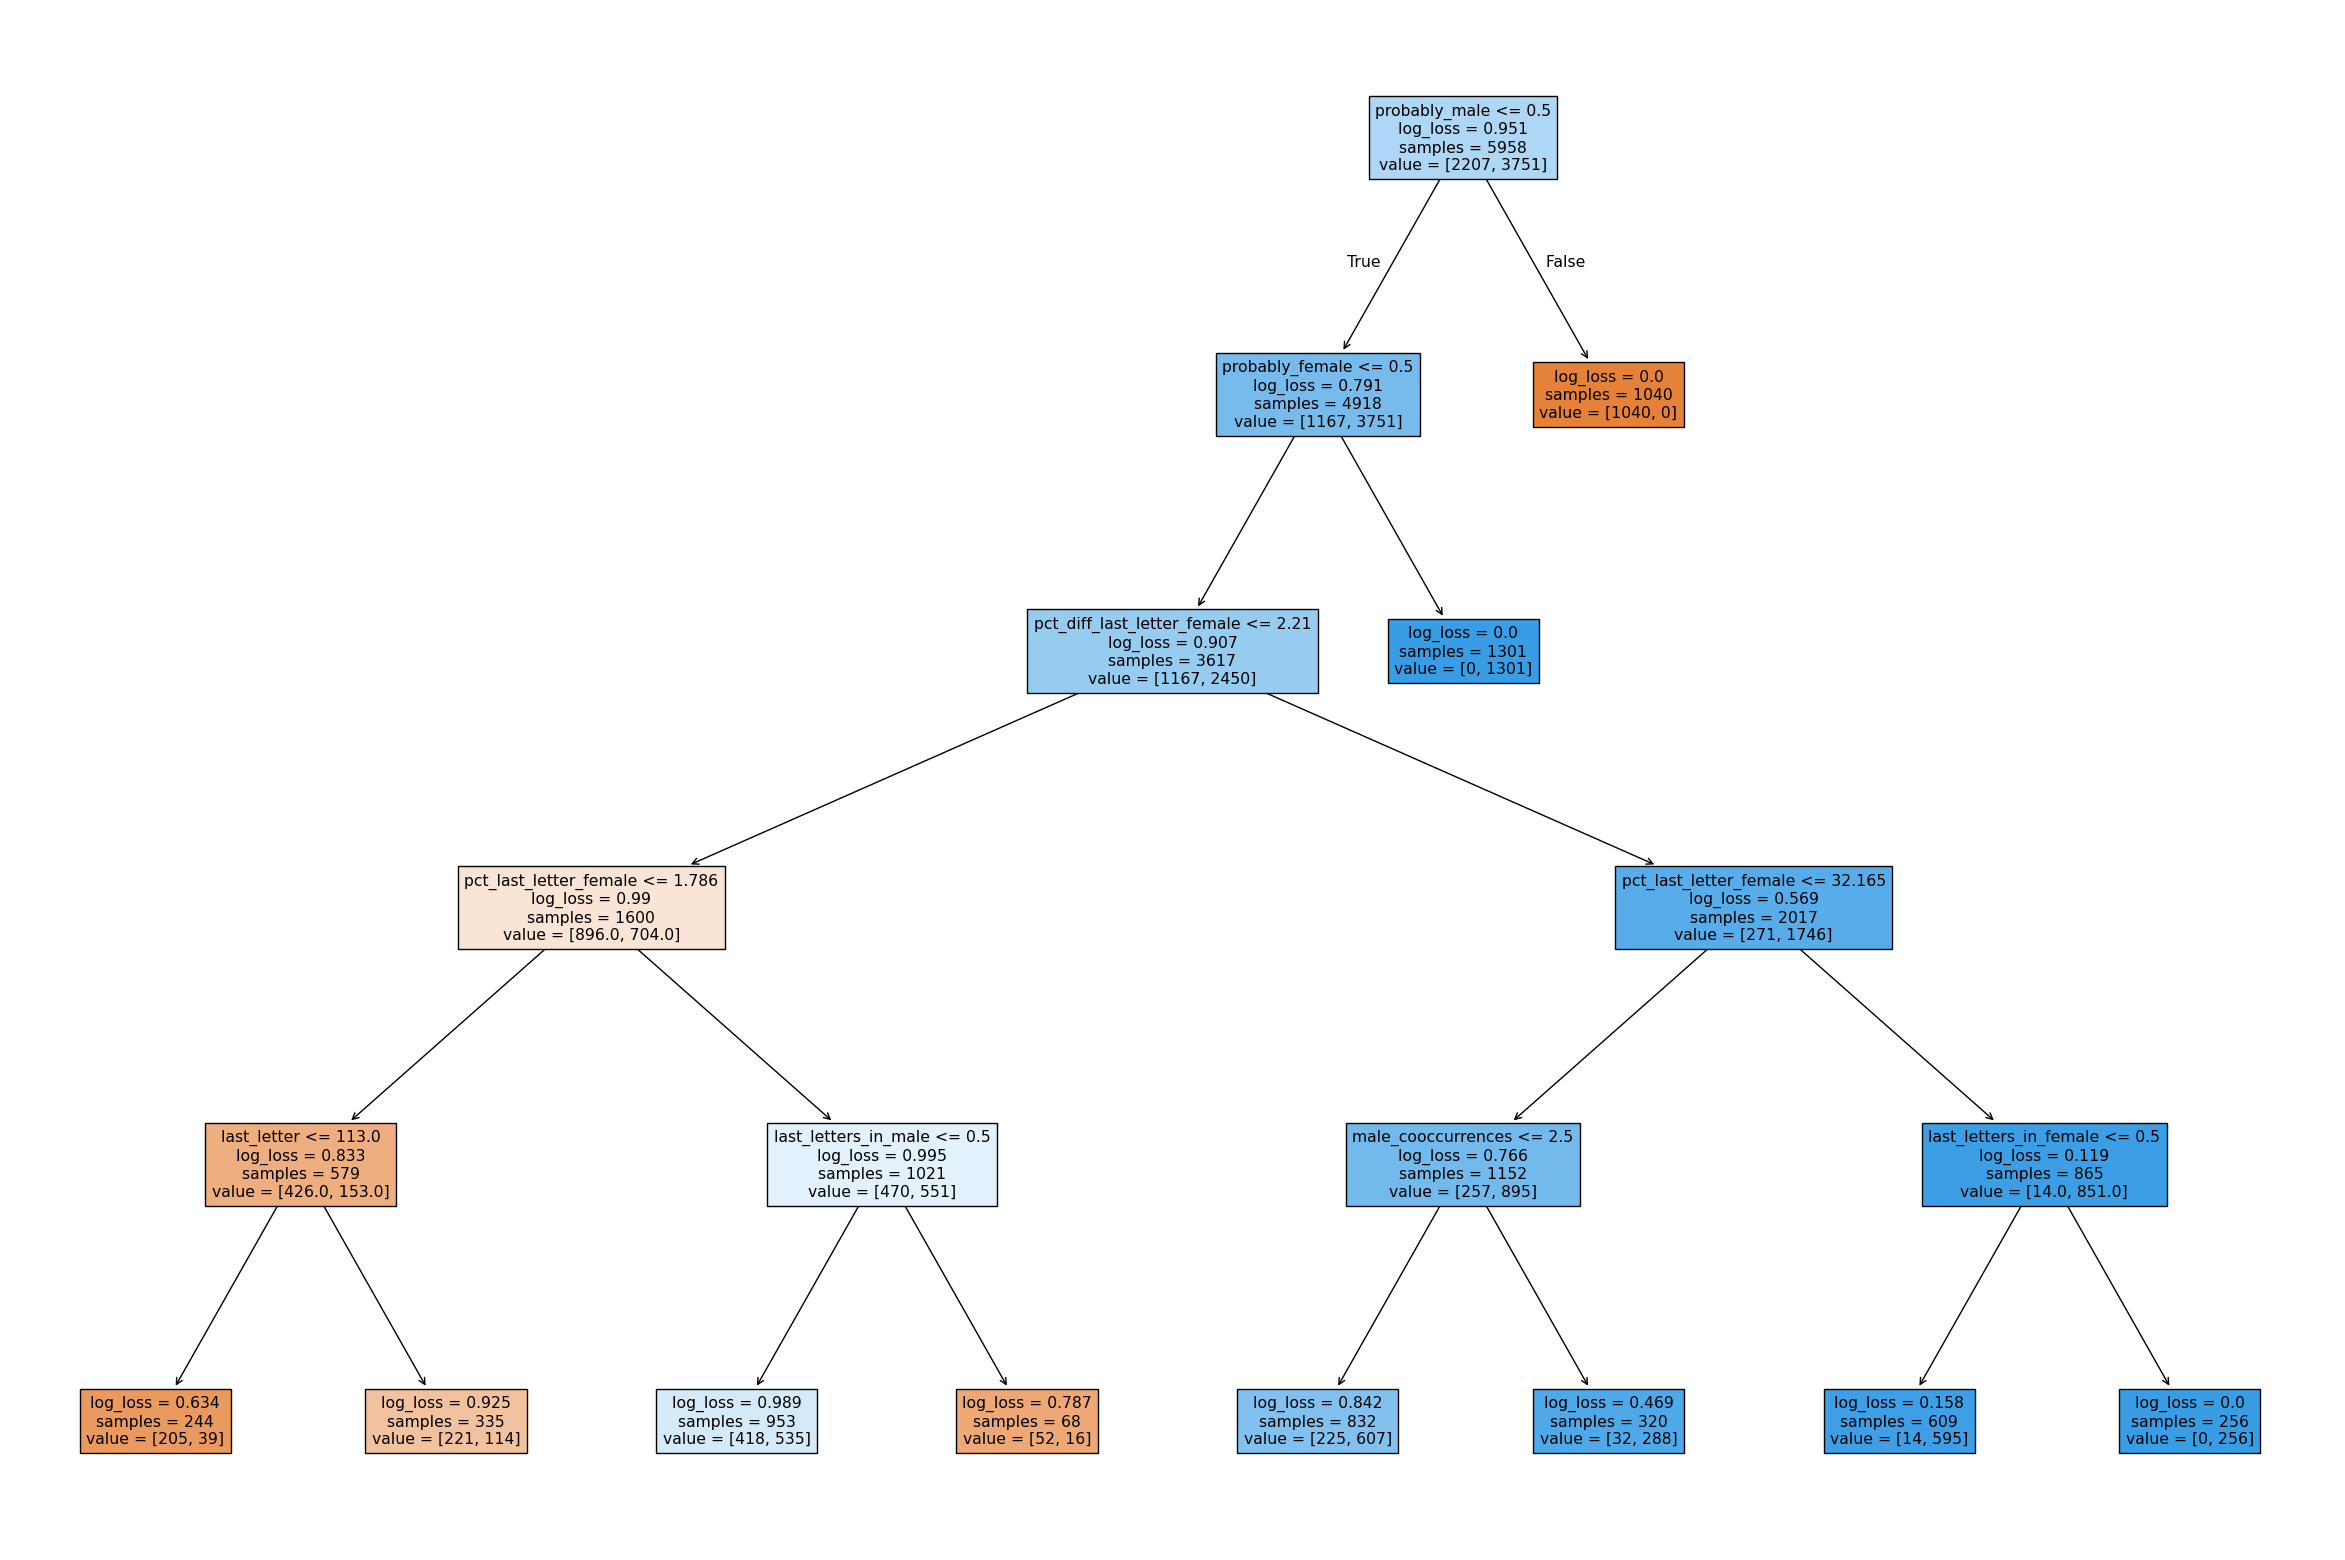

In [491]:
plt.figure(figsize=(30, 20))
tree.plot_tree(clf, feature_names=feature_names, filled=True)
plt.show()

### Test Set Tree Performance

In [493]:
%pip install supertree --quiet

In [494]:
from supertree import SuperTree

super_tree = SuperTree(clf,
                       X_test_features,
                       y_test,
                       feature_names,
                       target_names=["male", "female"])

# show tree in your notebook
super_tree.show_tree()


## Error Analysis

In [519]:
pd.DataFrame([list(compress(X_test, y_test != y_pred)), list(compress(y_test, y_test != y_pred))], index=["name", "gender"]).T.head(50)

,name,gender
0,Sylvie,1
1,Alasdair,0
2,Saundra,0
3,Jeremy,0
4,Jorge,0
5,Reggis,0
6,Hesther,1
7,Farrand,1
8,Winnie,0
9,Kevyn,1


## Comparison to Random Forest

In [488]:
clf = RandomForestClassifier(random_state=42, max_depth=5)
clf.fit(X_train_features, y_train)

y_pred = clf.predict(X_test_features)
print(classification_report(y_test, y_pred, target_names=["male", "female"]))
print(matthews_corrcoef(y_test, y_pred))

              precision    recall  f1-score   support

        male       0.73      0.71      0.72       736
      female       0.83      0.85      0.84      1250

    accuracy                           0.80      1986
   macro avg       0.78      0.78      0.78      1986
weighted avg       0.80      0.80      0.80      1986

0.565968581158982
